In [1]:
import sys
import os
import warnings
import glob
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

# Go up one directory from 'notebooks/' to project root
project_root = os.path.abspath('..')
sys.path.append(project_root)

In [2]:
from src.utils_all import *
from src.utils_data import *
from src.transformation_utils import *

from src.AE_RTM.AE_RTM_architectures import *
from src.AE_RTM.trainer_ae_rtm import *
import pickle

import torch
from torch.utils.data import DataLoader, TensorDataset
from huggingface_hub import hf_hub_download


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

1.8.1+cu111
True
GPU is available. Using GPU for computation.


In [4]:
def load_model(main_path, input_shape, type_s, perc=100):
    # open a file, where you stored the pickled data
    file = open(os.path.join(main_path, 'scaler_all_{}.pkl'.format(perc)), 'rb') 
    path_model = os.path.join(main_path, 'best_model.h5')

    # dump information to that file
    scaler_list = pickle.load(file)

    settings_dict = {
        'epochs': None,
        'train_loader': None,
        'unlabeled_loader' : None,
        'valid_loader': None,
        'checkpoint_dir': None, 
        'batch_size': None,
        'learning_rate': None,
        'early_stop': True,
        'patience': None,
        'scaler_model': scaler_list,
        'input_shape' : input_shape,
        'type':type_s,
        'log_epoch' : None,
        'lamb': None,
        'loss_recons_criterion': CosineSimilarityLoss()
    }


    sets = Settings_ae()
    sets.update_from_dict(settings_dict)

    test_reg = Trainer_AE_RTM(sets)
    test_reg.dataset_setup()
    test_reg.model_setup()

    test_reg.model = torch.load(path_model)

    return test_reg

def load_model_HF(repo_id, model_id, input_shape, type_s, perc=100):
    # Download files from Hugging Face Hub
    config_file = hf_hub_download(
        repo_id=repo_id,
        filename= os.path.join(model_id, 'scaler_all_{}.pkl'.format(perc))
    )

    path_model = hf_hub_download(
        repo_id=repo_id,
        filename=os.path.join(model_id, 'best_model.h5')
    )

    # Load pickled scaler
    with open(config_file, 'rb') as f:
        scaler_list = pickle.load(f)

    settings_dict = {
        'epochs': None,
        'train_loader': None,
        'unlabeled_loader' : None,
        'valid_loader': None,
        'checkpoint_dir': None, 
        'batch_size': None,
        'learning_rate': None,
        'early_stop': True,
        'patience': None,
        'scaler_model': scaler_list,
        'input_shape' : input_shape,
        'type':type_s,
        'log_epoch' : None,
        'lamb': None,
        'loss_recons_criterion': CosineSimilarityLoss()
    }


    sets = Settings_ae()
    sets.update_from_dict(settings_dict)

    test_reg = Trainer_AE_RTM(sets)
    test_reg.dataset_setup()
    test_reg.model_setup()

    test_reg.model = torch.load(path_model)

    return test_reg


# def eval(main_path, valid_loader, input_shape, type_s, perc=100):
#     test_reg = load_model(main_path, valid_loader, input_shape, type_s, perc=perc)

def eval(valid_loader, input_shape, type_s, perc=100, HF=False, model_id=None, repo_id=None, main_path=None):
    if(HF):
        test_reg = load_model_HF(repo_id, model_id, input_shape, type_s, perc=100)
    else:
        test_reg = load_model(main_path, input_shape, type_s, perc=perc)

    preds = torch.empty(0,8).to(device)
    ori = torch.empty(0,8).to(device)

    test_reg.model.eval()

    with torch.no_grad():
        for _, val_sample in enumerate(valid_loader):
            data_val, lb_bx_val = val_sample
            
            lb_bx_val = lb_bx_val.to(device).float()
            data_val = data_val.squeeze().float().to(device)
            
            x_val, _ = test_reg.model(data_val)
            
            ori = torch.cat((ori.data,lb_bx_val.data), dim=0)
            preds = torch.cat((preds.data,x_val[:,:].data), dim=0)


    if(test_reg.settings.scaler_model is not None):
        print(test_reg.transformation_layer_inv)
        preds = test_reg.transformation_layer_inv(preds) ### shoud keep the sam eorder of labels !!!
        
    ori_lb = pd.DataFrame(ori.cpu(), columns=ls_tr[:])
    df_tr_val = pd.DataFrame(preds.cpu(), columns=ls_tr[:])
    df_tr_val['cbc'] = df_tr_val['cm']-df_tr_val['cp']

    return ori_lb, df_tr_val



In [ ]:
######## Data ########
ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]
# percentage_tr = 1
# batch_size = 128 
seed = 155

path_data_lb = os.path.join(project_root, "Datasets/50_all_traits.csv")

# ### if locally
# checkpoints_path = 'ae_rtm/checkpoints_Gan_NoRTM_250507_1536_gp0UNlabels_155/'
# main_path = os.path.join(project_root, checkpoints_path)

##### Or on HF ##
repo_id = "Avatarr05/Multi-trait_SSL"
model_id = 'ae_rtm/checkpoints_AE_RTM_FR_seed240'


In [6]:
from datasets import load_dataset

### labeled_splits: train ###
test_dataset = load_dataset("Avatarr05/GreenHyperSpectra", 'labeled_splits', split="test")
test_dataset = test_dataset.to_pandas().drop(['Unnamed: 0', ], axis=1)

X_val = test_dataset.loc[:, '400':'2450']
y_val = test_dataset[ls_tr]

meta_val = test_dataset.iloc[:, :1]

# Validation dataset
x_p_val = torch.tensor(X_val.values, dtype=torch.float)
lb_p_val = torch.tensor(y_val.values,dtype=torch.float)

test_dataset = TensorDataset(x_p_val, lb_p_val)
valid_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
### On HF ##
ori_lb, df_tr_val = eval(valid_loader, 1720, 'full', perc=100, HF=True, model_id=model_id, repo_id=repo_id)
# ## Locally 
# ori_lb, df_tr_val = eval(valid_loader, 1720, 'full', perc=100, main_path=main_path)

val_mertics = eval_metrics(ori_lb, df_tr_val)

val_mertics

StaticTransformationLayer()


,r2_score,RMSE,nRMSE (%),MAE,Bias,RPD,spearmanr_squared
cab,0.653339,7.983219,14.688292,5.746894,0.168023,1.700578,0.665119
cw,0.729920,0.004671,11.055388,0.002914,0.000422,1.926491,0.633698
cm,0.768626,0.003048,8.910960,0.001793,0.000337,2.080358,0.683705
LAI,0.619186,1.090027,16.192948,0.782341,-0.094908,1.623340,0.642783
cp,0.716989,0.000235,9.263135,0.000150,0.000023,1.881437,0.674627
cbc,0.789665,0.002929,8.640856,0.001674,0.000197,2.182407,0.666293
car,0.669299,1.646693,11.621014,1.130435,-0.078495,1.741613,0.628032
anth,0.171414,0.393658,20.288837,0.258628,0.076963,1.106181,0.355932


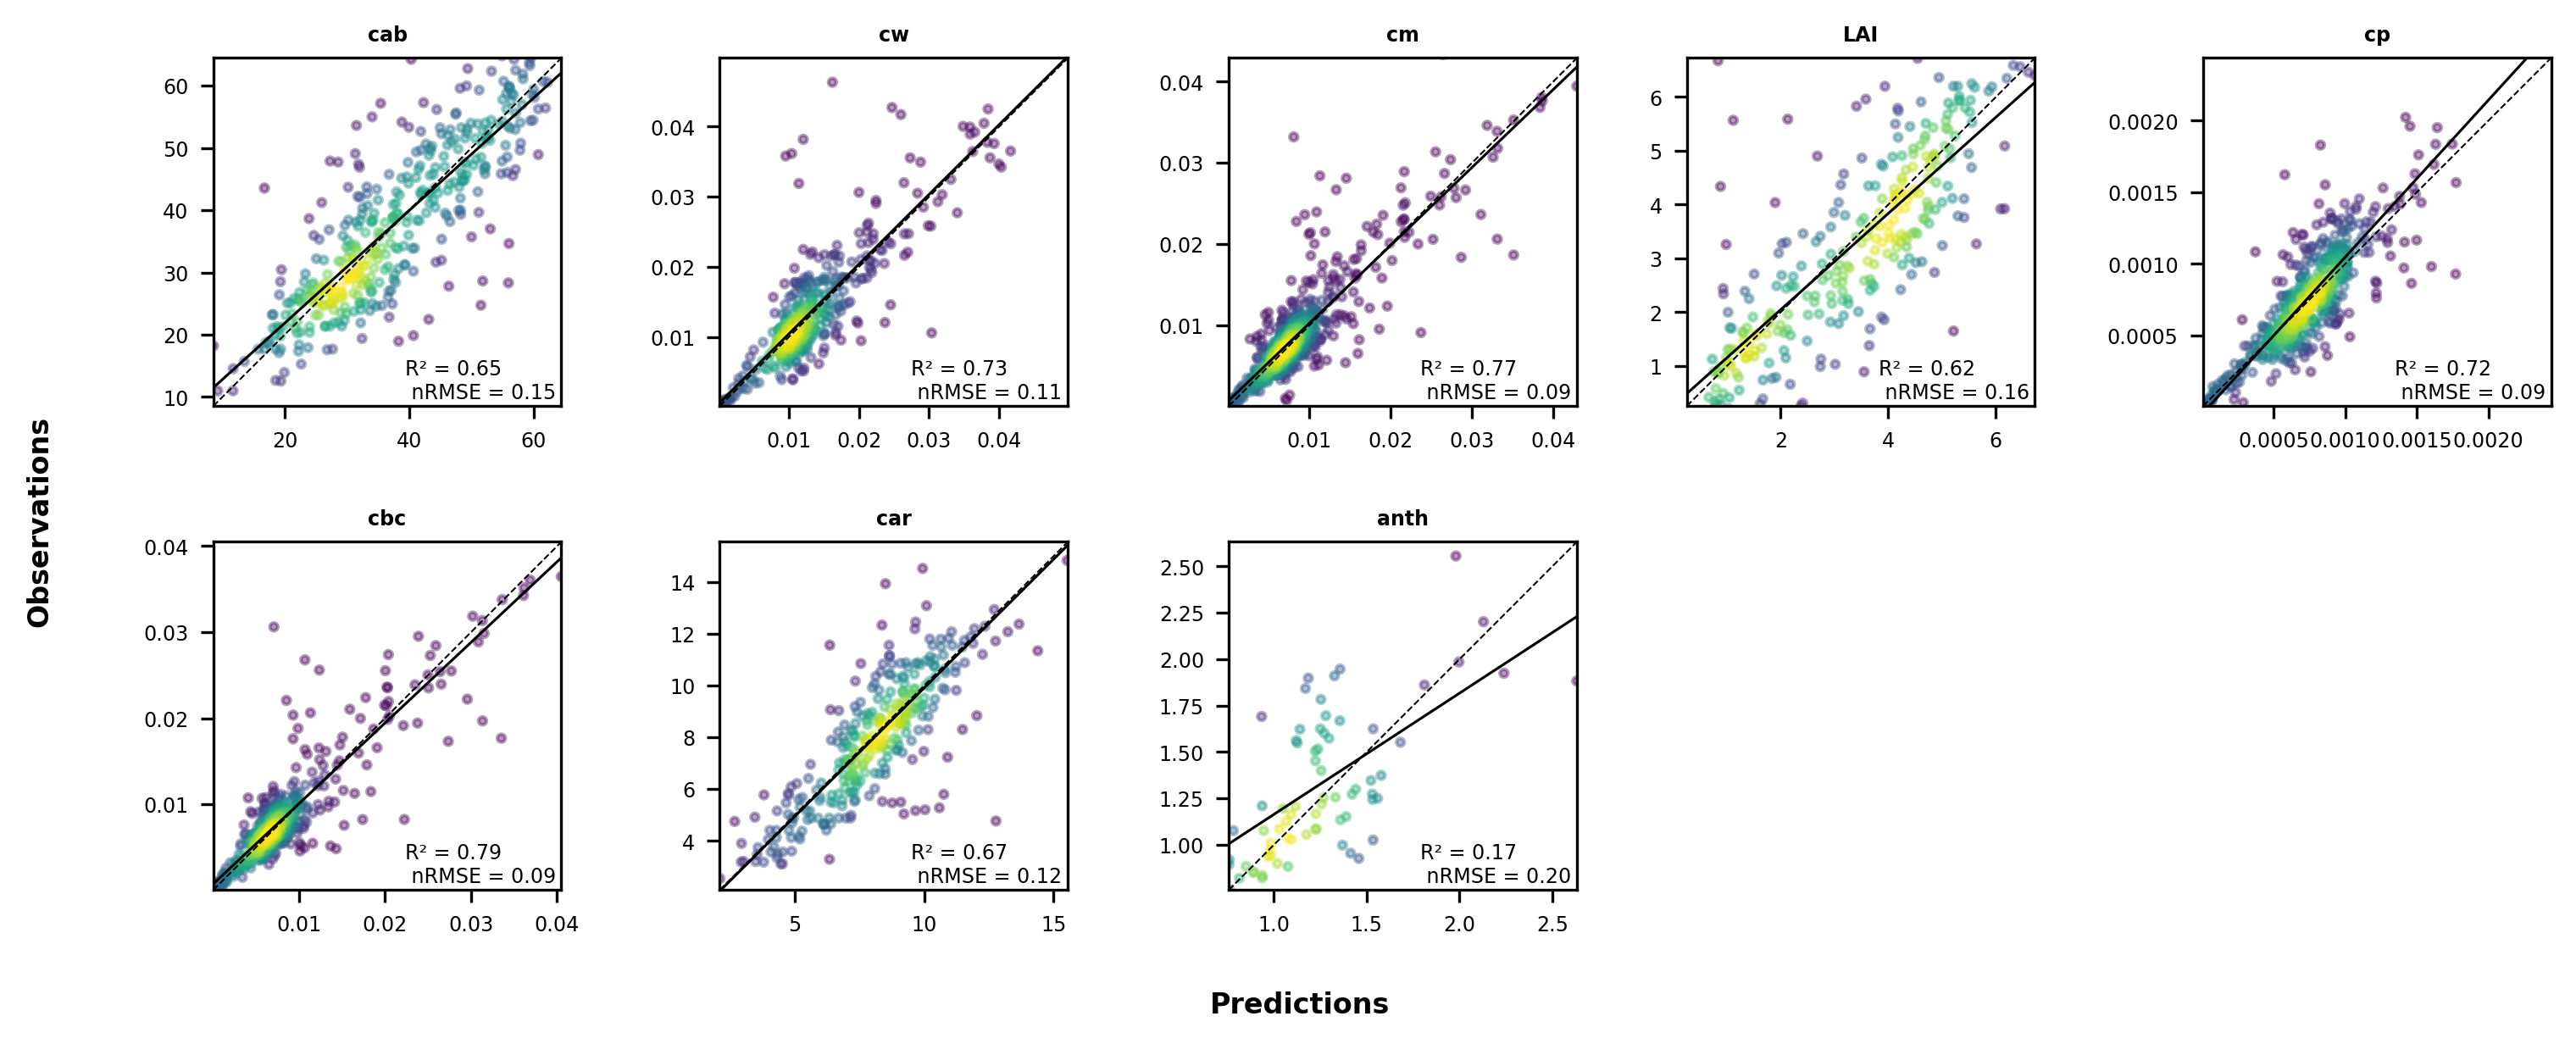

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from scipy.stats import gaussian_kde

import seaborn as sns

# --- Settings ---
size = 5.7
quantile_vis = 1
figsize = (10, 4)

plt.rc('font', size=size)
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.5

a = 2  # rows
b = 5  # columns
c = 1  # subplot counter

# --- Prepare data --- 
Traits = test_tr = list(ori_lb.columns)

fig = plt.figure(figsize=figsize, dpi=300, constrained_layout=True)

for tr in range(len(test_tr)):
    pred = df_tr_val.iloc[:, tr]
    true = ori_lb.iloc[:, tr]

    norm = (np.nanquantile(true, 0.99) - np.nanquantile(true, 0.01))

    # Reset indices and align data
    f = pred.copy().reset_index(drop=True)
    y = true.copy().reset_index(drop=True)

    # Drop NaNs
    idx = np.union1d(f[f.isna()].index, y[y.isna()].index)
    f.drop(idx, inplace=True)
    y.drop(idx, inplace=True)

    # Metrics
    r2 = r2_score(y, f)
    nrmse = math.sqrt(mean_squared_error(y, f)) / norm
    nmae = mean_absolute_error(y, f) / norm

    # Plotting
    ax1 = plt.subplot(a, b, c)
    plt.axis('square')

    lim_max = min(f.quantile(quantile_vis), y.quantile(quantile_vis))
    lim_min = max(f.quantile(1 - quantile_vis), y.quantile(1 - quantile_vis))

    ax1.set_xlim(lim_min, lim_max)
    ax1.set_ylim(ax1.get_xlim())
    ax1.set_aspect('equal', adjustable='box')

    # Diagonal reference line
    sns.lineplot(x=(lim_min, lim_max), y=(lim_min, lim_max),
                 ax=ax1, color='black', linestyle='dashed', legend=False)

    # --- Density coloring ---
    xy = np.vstack([f, y])
    z = gaussian_kde(xy)(xy)
    idx_sorted = z.argsort()
    f_sorted, y_sorted, z_sorted = f.iloc[idx_sorted], y.iloc[idx_sorted], z[idx_sorted]

    scatter = ax1.scatter(f_sorted, y_sorted, c=z_sorted, cmap='viridis', s=5, alpha=0.4)

    # Regression line (fit_reg=True is not needed here)
    sns.regplot(x=f, y=y, ax=ax1, scatter=False, color='black', ci=False)

    # Annotate metrics
    ann = 'R² = {0:.2f} \n nRMSE = {1:.2f}'.format(r2, nrmse)
    ax1.annotate(ann,
                 xy=(0.55, 0.01),
                 xycoords='axes fraction',
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 size=size)

    # Trait title
    ax1.set_title(test_tr[tr], y=1.1, pad=-5, fontdict={
                  'fontsize': size, 'fontweight': 'bold'})

    plt.xlabel(" ")
    plt.ylabel(" ")

    c += 1

# Shared axis labels
fig.supxlabel('Predictions', size=8, fontweight='bold', ha='center')
fig.supylabel('Observations', size=8, fontweight='bold', ha='center')

# fig.savefig('GAN_Trans11.svg')
# fig.savefig('GAN_Trans11.png')

plt.show()